# Test the ADC

## Import some libraries

In [507]:
import numpy as np
import pyaudio
import time
from saleae import automation
import os
import os.path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import cicsim as cs

## Generate the audio stream

In [508]:
def startAudioStream(nbpt,fs,f,volume,duration):
    p = pyaudio.PyAudio()
    fs = 48000  # sampling rate, Hz, must be integer
    lsamples = (np.sin(2 * np.pi * np.arange(fs * (duration + 2)) * f / fs)).astype(np.float32)
    hsamples = -lsamples
    #hsamples = lsamples
    samples = np.array([val for pair in zip(lsamples[0:len(lsamples)-1], hsamples[1:len(hsamples)]) for val in pair])

    output_bytes= (volume * samples).tobytes()

    stream = p.open(format=pyaudio.paFloat32,
                    channels=2,
                    rate=fs,    
                    output=True)

    start_time = time.time()

    stream.write(output_bytes)
    stream.stop_stream()
    stream.close()
    p.terminate()

## Capture from Saleae logic

In [509]:
def captureAnalyzer(nbpt,fs,fin,volume,duration):
    with automation.Manager.connect(port=10430) as manager:

        device_configuration = automation.LogicDeviceConfiguration(
            enabled_digital_channels=[0, 1, 2, 3,4,5,6,7,8],
            digital_sample_rate=125_000_000,
            digital_threshold_volts=3.3,
        )
        capture_configuration = automation.CaptureConfiguration(
            capture_mode=automation.TimedCaptureMode(duration_seconds=duration)
        )

        with manager.start_capture(
                device_id='EB3F928DB6DEBCEF',
                device_configuration=device_configuration,
                capture_configuration=capture_configuration) as capture:

            capture.wait()
            analyzer = capture.add_analyzer('Simple Parallel', label=f'Test Analyzer', settings={
                'D0': 0,
                'D1': 1,
                'D2': 2,
                'D3': 3,
                'D4': 4,
                'D5': 5,
                'D6': 6,
                'D7': 7,
                'Clock': 8,
                'Clock State': 'Falling edge',
            })

            output_dir = os.path.join(os.getcwd(), f'data/output-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_{nbpt}_{int(fin/1000)}k_{int(fs/1000)}k_{volume}')
            os.makedirs(output_dir)
            analyzer_export_filepath = os.path.join(output_dir, 'spi_export.csv')
            print(analyzer_export_filepath)
            capture.legacy_export_analyzer(
                filepath=analyzer_export_filepath,
                analyzer=analyzer,
                radix=automation.RadixType.DECIMAL
            )
    return analyzer_export_filepath

## Start input, and capture ADC

Compute input frequency. We want the input frequency to be in a odd FFT bin. Since we have 2**N samples in an FFT, it's sufficient to have an odd FFT bin.

In [510]:
nbpt = 2**16
fs = 16e3
fin = 0.1e3
fbin = int(fin/fs*nbpt)
if(fbin % 2 == 0):
    fbin = fbin + 1
fin = fbin*fs/nbpt
duration = nbpt/fs
print(fin,fbin,fs,nbpt,duration)


99.853515625 409 16000.0 65536 4.096


In [511]:
from threading import Thread
volume = 0.438  
print("Starting Audio")
t = Thread(target=startAudioStream, args=[nbpt,fs,fin,volume,duration])
t.start()
#time.sleep(1)
print("Capture")
fcapture = captureAnalyzer(nbpt,fs,fin,volume,duration)


Starting Audio
Capture
/Users/wulff/data/2024/tt06-sar/meas/data/output-2025-01-29_16-52-06_65536_0k_16k_0.438/spi_export.csv


## Post process

STD 89.85037037032843
MEAN -0.14278878504672898


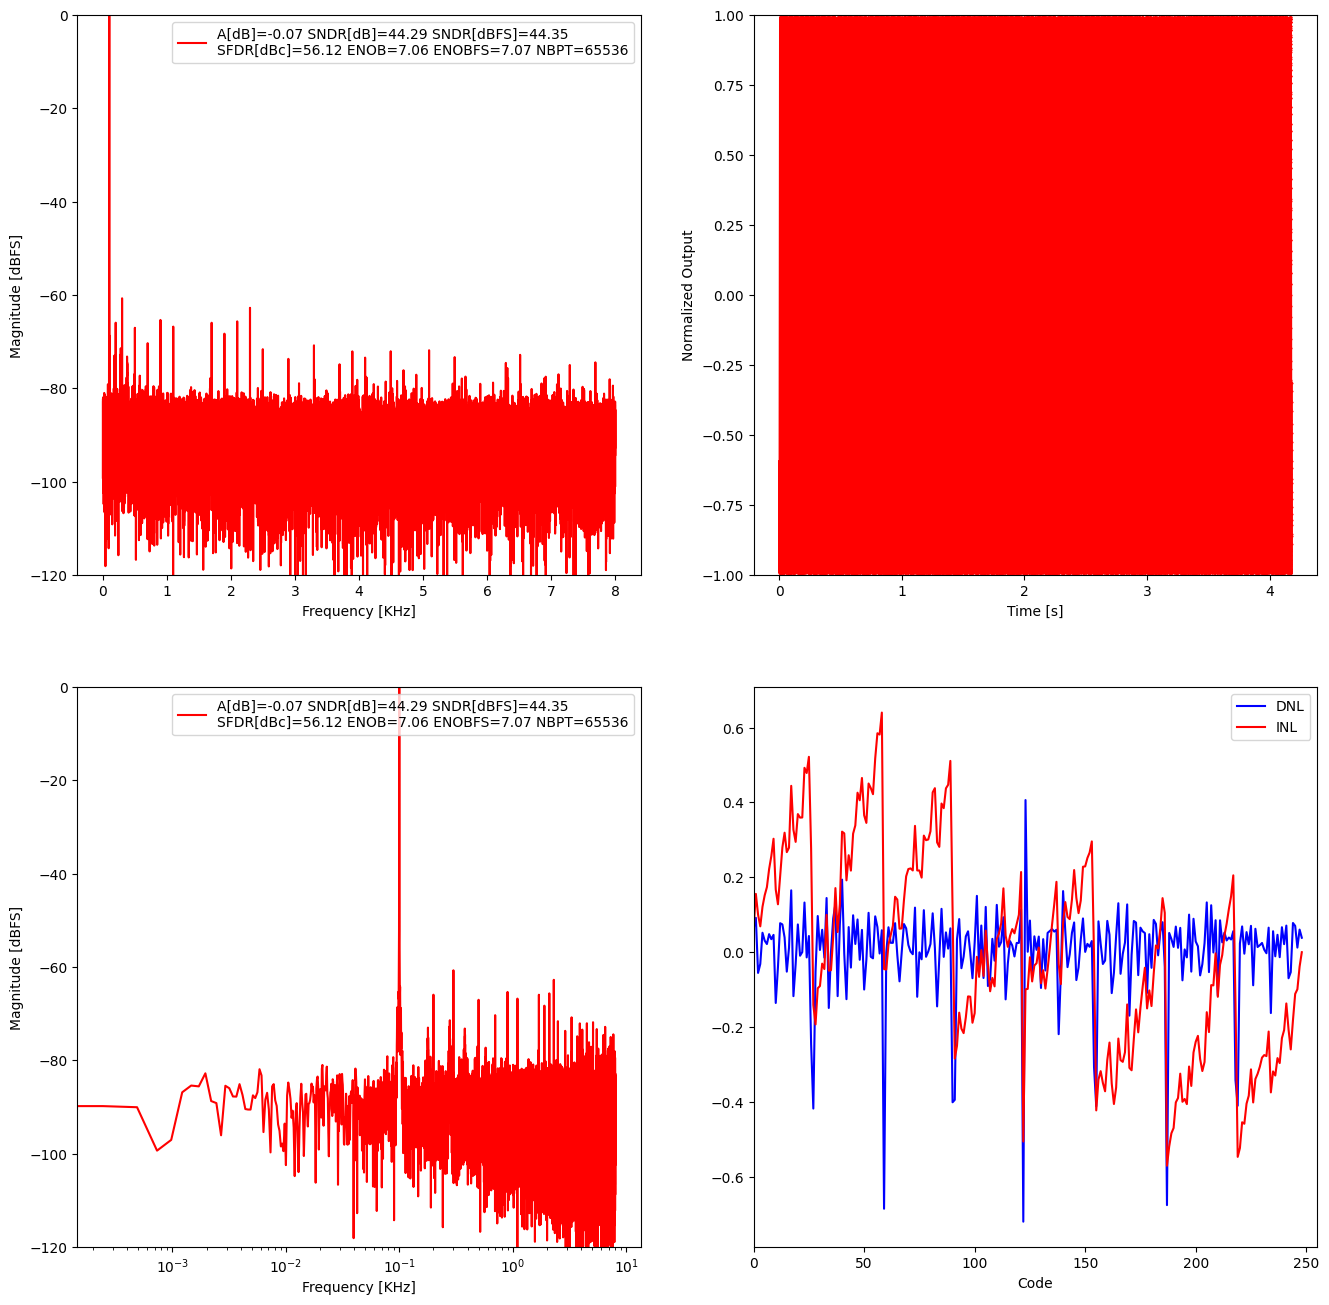

<Figure size 640x480 with 0 Axes>

In [527]:
        
def toTwosComplement(data):
        if(data > 127):
            data = data - 256
        return data

def paramToStr(data):
    return "A[dB]=%.2f SNDR[dB]=%.2f SNDR[dBFS]=%.2f\nSFDR[dBc]=%.2f ENOB=%.2f ENOBFS=%.2f NBPT=%d" %(data["amp"],data["sndr"],data["sndrfs"],data["sfdr"],data["enob"],data["enobfs"],data["nbpt"])

def inlDnl(y):
     
    # Adapted from Boris Murmann, 2002, inldnl matlab script


    # histogram boundaries
    minbin=min(y)
    maxbin=max(y)
    numbins=maxbin-minbin+1

    # histogram
    h= np.histogram(y, bins=numbins, range=(minbin,maxbin))[0]
    # cumulative histogram
    ch= np.cumsum(h)

    # transition levels
    T = -np.cos(np.pi*ch/sum(h))
    
    #linearized histogram
    hlin = T[2:] - T[1:len(T)-1]

    # truncate at least first and last bin, more if input did not clip ADC
    trunc=2;
    hlin_trunc = hlin[1+trunc:len(hlin)-trunc]

    # calculate lsb size and dnl
    lsb= np.sum(hlin_trunc) / (len(hlin_trunc))
    dnl= [0] + hlin_trunc/lsb-1
    #misscodes = length(find(dnl<-0.9));

    # calculate inl
    inl= np.cumsum(dnl)
    return dnl,inl
     

def plotFFT(fcapture,fs):
    df4 = pd.read_csv(fcapture)
    df4["val"] = df4["Value"].apply(toTwosComplement)
    df4["time"] = df4["Time [s]"]
    df4.set_index("time",inplace=True)
    df4.index = pd.to_datetime(df4.index,unit='s')

    fig,ax = plt.subplots(2,2,figsize=(16,16))
    scc = cs.SimCalc()
    y = df4["val"]/128
    print("STD",df4["val"].std())
    print("MEAN",df4["val"].mean())
    (data,ydB)   = scc.fftWithHanning(y.to_numpy())
    f = np.linspace(0,0.5,num=int(len(ydB)))*fs/1e3
    #ax[0].semilogx(f,ydB,label=paramToStr(data),color="red")
    ax[1][0].semilogx(f,ydB,label=paramToStr(data),color="red")
    ax[1][0].set_ylabel("Magnitude [dBFS]")
    ax[1][0].set_xlabel("Frequency [KHz]")
    ax[1][0].set_ylim(-120,0)
    ax[1][0].legend()
    ax[0][0].plot(f,ydB,label=paramToStr(data),color="red")
    ax[0][0].set_ylabel("Magnitude [dBFS]")
    ax[0][0].set_xlabel("Frequency [KHz]")
    ax[0][0].set_ylim(-120,0)
    ax[0][0].legend()
    t = np.linspace(0,len(y),num=len(y))/fs
    ax[0][1].plot(t,y,marker=".",linestyle="-",color="red",markersize=1)
    ax[0][1].set_ylim(-1,1)
    ax[0][1].set_ylabel("Normalized Output")
    ax[0][1].set_xlabel("Time [s]")
    #ax[1][1].hist(y,bins=256)
    (dnl,inl)= inlDnl(df4["val"])
    ax[1][1].plot(dnl,label="DNL",color="blue")
    ax[1][1].plot(inl,label="INL",color="red")
    ax[1][1].legend()
    #ax[1][1].set_ylabel("DNL")
    ax[1][1].set_xlabel("Code")
    #ax[1][1].set_ylim(,0.5)
    ax[1][1].set_xlim(0,255)
    
    #ax[1].set_ylim(-0.25,0.25)
    #ax[1].set_xlim(0.0005,0.001)
    #ax[1].set_xlim(0.1,0.2)
    plt.savefig(fcapture.replace(".csv",".png"))
    plt.show()
    plt.tight_layout()
plotFFT(fcapture,fs)
    
